In [215]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

In [216]:
file = open('cleansed_data.pickle', 'rb')
data = pickle.load(file)
file.close()

In [217]:
X = data.drop(columns=['total_cases', 'week_start_date', 'year', 'weekofyear'])
y = data['total_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# SVM Regressor

In [218]:
svr = SVR()

kfold = KFold(n_splits=10, random_state=42)
cv_score = cross_val_score(svr, X_train, y_train, cv=kfold, scoring='mean_absolute_error')
print("MAE mean: {}, SD: {}".format(cv_score.mean(), cv_score.std()))

MAE mean: -17.17951349023307, SD: 5.034641018259512


In [219]:
cv_score

array([-12.25335776, -16.42867675, -20.61752028, -21.3760483 ,
       -13.57130569, -15.17432691, -13.32513925, -16.28179917,
       -29.48180851, -13.28515228])

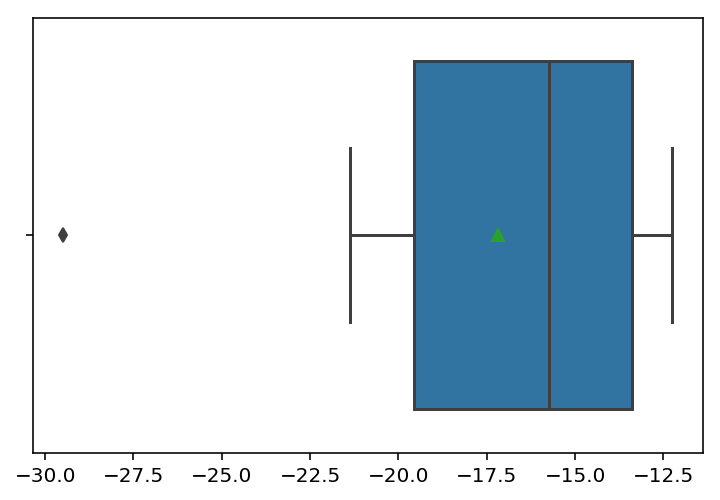

In [220]:
sns.boxplot(cv_score, showmeans=True)

In [221]:
svr.fit(X_train, y_train)
y_test_pred = svr.predict(X_test)

In [222]:
mean_absolute_error(y_test, y_test_pred)

18.175490487652116

(-20, 120)

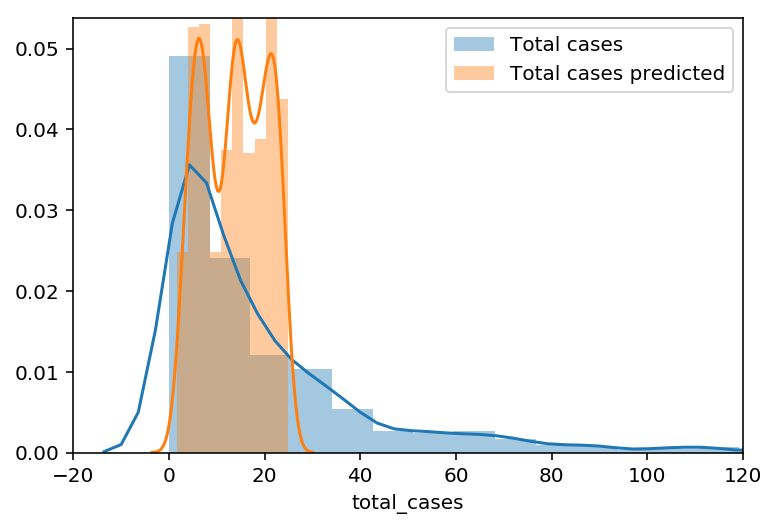

In [223]:
f, ax = plt.subplots(1)
sns.distplot(y_test, ax=ax, label='Total cases')
sns.distplot(y_test_pred, ax=ax, label='Total cases predicted')

ax.legend()
ax.set_xlim([-20,120])

# Gradient boosting regressor

In [224]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=kfold,
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 2, random_state=42,
                               return_train_score = True)

# Fit on the training data
rcv = random_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls 
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls 
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls 
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=5, loss=ls 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=6, ma

KeyboardInterrupt: 

In [167]:
rcv.best_score_

-18.257968848872647

In [209]:
gbr = GradientBoostingRegressor(**rcv.best_params_)

In [210]:
kfold = KFold(n_splits=10, random_state=42)
cv_score = cross_val_score(gbr, X_train, y_train, cv=kfold, scoring='mean_absolute_error')
print("MAE mean: {}, SD: {}".format(cv_score.mean(), cv_score.std()))

MAE mean: -18.01219482146967, SD: 3.276024048792365


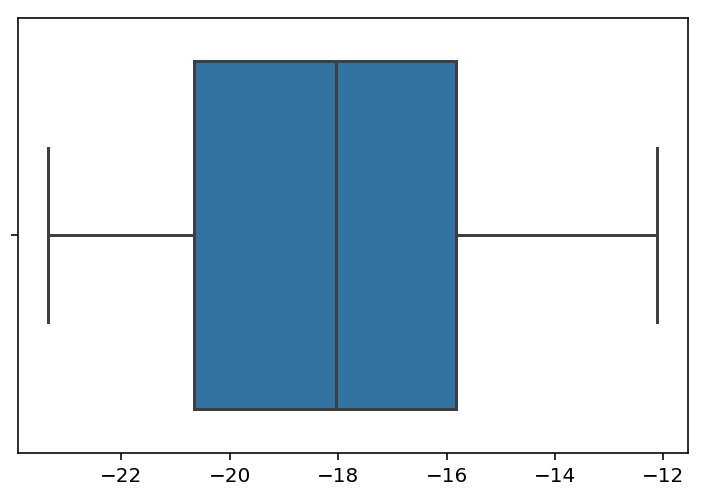

In [211]:
sns.boxplot(cv_score)

In [213]:
gbr.fit(X_train, y_train)
y_test_pred = gbr.predict(X_test)

(-20, 120)

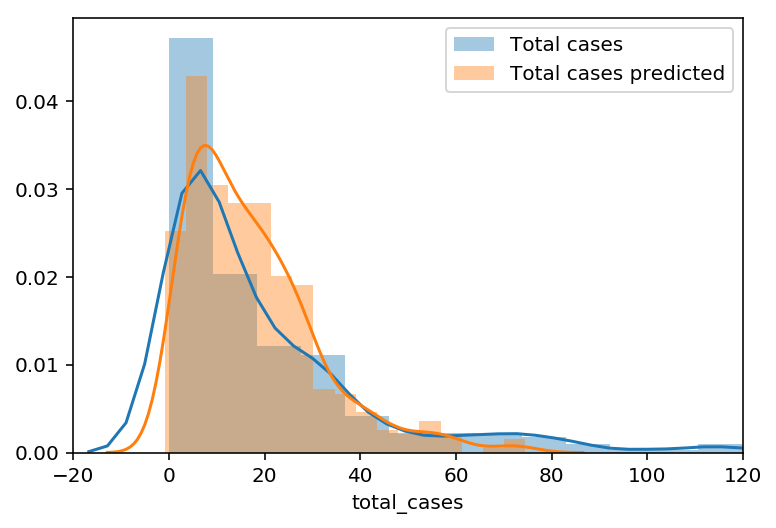

In [214]:
f, ax = plt.subplots(1)
sns.distplot(y_test, ax=ax, label='Total cases')
sns.distplot(y_test_pred, ax=ax, label='Total cases predicted')

ax.legend()
ax.set_xlim([-20,120])

# Predict Test set

In [190]:
file = open('cleansed_data_test.pickle', 'rb')
test = pickle.load(file)
file.close()

x_test = test.drop(columns=['week_start_date', 'year', 'weekofyear'])

In [191]:
gbr.fit(X_train, y_train)
test_pred = gbr.predict(x_test)

In [192]:
test['city'] = x_test.apply(lambda x: 'iq' if x['city_iq'] == 1 else 'sj', axis=1)

In [193]:
test_submit = test[['city', 'year', 'weekofyear']]

In [194]:
test_submit['total_cases'] = test_pred
test_submit['total_cases'] = test_submit['total_cases'].apply(lambda x: int(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [195]:
# test_submit.to_csv('IUddin_2018-08-15.csv', index=False)

In [196]:
test_submit

,city,year,weekofyear,total_cases
0,sj,2008,18,15
1,sj,2008,19,21
2,sj,2008,20,18
3,sj,2008,21,16
4,sj,2008,22,10
5,sj,2008,23,15
6,sj,2008,24,18
7,sj,2008,25,18
8,sj,2008,26,16
9,sj,2008,27,19
